In [1]:
import pandas as pd
import seaborn as sns
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d

In [2]:
color_names = []
for j in mcolors.CSS4_COLORS:
    color_names.append(j)

## Load dos dados dos filtros

In [3]:
import json

with open('../data/result_no_rebin.json', 'r') as JSON:
    json_dict = json.load(JSON)
data = json.loads(json_dict)    

In [4]:
with open('../data/cygno_results.json', 'r') as JSON:
    json_dict = json.load(JSON)
data_cygno = json.loads(json_dict) 

In [5]:
data.keys()

dict_keys(['Image_index', 'Filter_name', 'count', 'Filter_parameter', 'time', 'ROC'])

In [6]:
data_cygno.keys()

dict_keys(['Image_index', 'Filter_name', 'count', 'Filter_parameter', 'time', 'ROC'])

In [7]:
data['ROC'].keys()

dict_keys(['array', 'energy', 'energy_real', 'method', 'threshold'])

In [8]:
np.array(data['ROC']['energy']).shape

(100, 81, 163)

In [9]:
np.array(data_cygno['ROC']['energy']).shape

(100, 81, 1)

In [38]:
energy = np.append(np.array(data['ROC']['energy']), np.array(data_cygno['ROC']['energy']), axis=2)
energy_real =np.append(np.array(data['ROC']['energy_real']), np.array(data_cygno['ROC']['energy_real']), axis=2)
time = np.append(np.array(data['time']), 100*['0'])
time = time.reshape(energy.shape[2],energy.shape[0])
energy_mean = energy.mean(axis=0)
energy_std = energy.std(axis=0)
energy_real_mean = energy_real.mean(axis=0)
energy_real_std = energy_real.std(axis=0)

### Calculating AUC of ROC's

In [11]:
curves = np.array(data['ROC']['array'])
curves.shape

(100, 2, 81, 163)

In [12]:
curves_cygno = np.array(data_cygno['ROC']['array'])
curves_cygno.shape

(100, 2, 81, 1)

In [13]:
curves = np.append(curves, curves_cygno, axis=3)

In [96]:
curves.shape

(100, 2, 81, 164)

In [14]:
sg_eff = curves[:,0,:,:]
bg_eff = curves[:,1,:,:]

In [15]:
sg_eff_mean, bg_eff_mean = sg_eff.mean(axis = 0), bg_eff.mean(axis = 0)
sg_eff_std, bg_eff_std = sg_eff.std(axis = 0), bg_eff.std(axis = 0)

In [16]:
names = []
params = []
names = data['Filter_name'][0:curves.shape[3]-1]
params = data['Filter_parameter'][0:curves.shape[3]-1]

In [17]:
names.append('cygno')
params.append(' ')

In [18]:
filter_names = names

In [19]:
#auc_mean = (abs(np.diff(sg_eff_mean, axis = 0))*bg_eff_mean[1:,:]).sum(axis = 0)
#print(names[auc_mean.argmax()] + ' - ' + 'params' + str(params[auc_mean.argmax()]))
f1_scores = ((2*sg_eff_mean*bg_eff_mean)/(sg_eff_mean+bg_eff_mean))
f1_best_scores = f1_scores.max(axis=0)

In [20]:
f1_scores_all = ((2*sg_eff*bg_eff)/(sg_eff+bg_eff))
f1_score_best_per_image = f1_scores_all.max(axis=1)
f1_score_best_per_image.shape

(100, 164)

bilateral: 
[9, 1, 9]
 Time :22
bm3D: 
[5]
 Time :14
cygno: 
 
 Time :0
gaussian: 
[11]
 Time :12
mean: 
[11]
 Time :21
median: 
[11]
 Time :20
nlmeans: 
[1, 11]
 Time :24
wiener: 
[1]
 Time :17


Text(0.5, 1.0, 'ROC curve')

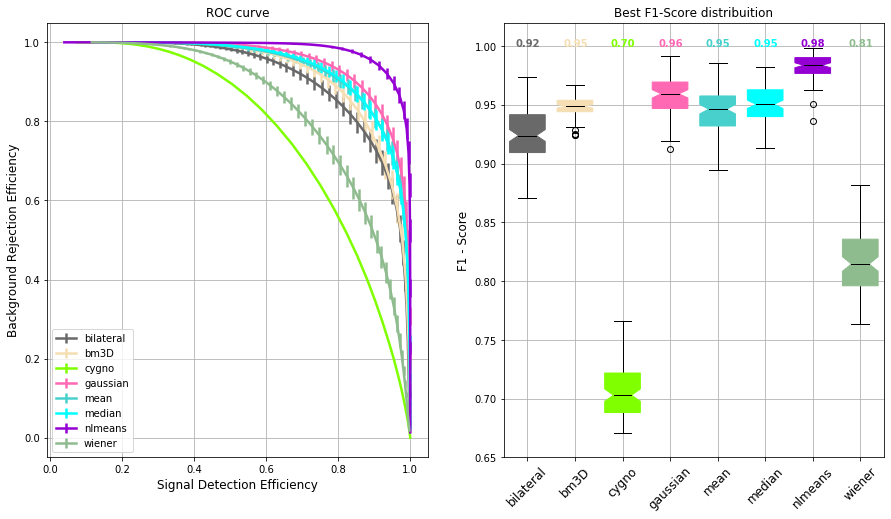

In [51]:
np.random.seed(287)
fig,ax = plt.subplots(1,2, figsize=(15,8))
filter_names = np.unique(names)
colors_index = np.random.randint(low=0, high=len(color_names), size=len(filter_names))
best_times = []
select_signals = []
for i,filter_name in list(enumerate(filter_names)):
    index = np.where(filter_name == np.array(names))[0]
    best_index = index[f1_best_scores[index].argmax()]
    best_time = time[best_index, :].astype(np.int64).mean()/(10**9)
    c = color_names[colors_index[i]]
    
    x = bg_eff_mean[:, best_index]
    y = sg_eff_mean[:, best_index]
    f_xy = interp1d(x, y, fill_value='extrapolate')
    select_signals.append(f_xy(0.99))
    ax[0].errorbar(sg_eff_mean[:, best_index], 
                 bg_eff_mean[:, best_index],
                 yerr = bg_eff_std[:, best_index]/np.sqrt(100),
                 label = names[best_index],
                 color = c, linewidth = 2.5)
    ax[1].boxplot(f1_score_best_per_image[:, best_index], 
                  positions = [i],
                  patch_artist=True,
                  notch = True,
                  boxprops=dict(facecolor=c, color=c),
                  capprops=dict(color='black'),
                  whiskerprops=dict(color='black'),
                  flierprops=dict(color='black', markeredgecolor='black'),
                  medianprops=dict(color='black'),
                  widths = 0.75)
    ax[1].text(i-0.25, 1, 
               str('%.2f'%np.median(f1_score_best_per_image[:, best_index])),
               color = c,
               fontweight = 'black')
    
    
    print(filter_name + ': \n' + str(params[best_index]) + '\n Time :' + str(int(best_time)))
    
    
ax[0].set_xlabel('Signal Detection Efficiency', fontsize=12)
ax[0].set_ylabel('Background Rejection Efficiency', fontsize=12)
ax[0].grid()
ax[0].legend()  
ax[1].grid()
ax[1].set_xticks(range(0, len(filter_names)), list(filter_names))
ax[1].set_xticklabels(np.append(filter_names,'None'),
                    rotation=45, fontsize=12)
ax[1].set_ylim(0.65, 1.02)
ax[1].set_ylabel('F1 - Score', fontsize=12)
ax[1].set_title('Best F1-Score distribuition')
ax[0].set_title('ROC curve')    

In [47]:
select_signals

[array(0.44686005),
 array(0.50615304),
 array(0.26670228),
 array(0.56835682),
 array(0.49982746),
 array(0.51662808),
 array(0.7690647),
 array(0.33632931)]

## Energy Analysis

In [28]:
n_pixels_mean = np.array(data['count']).astype(np.int).mean()
print("Número médio de pixels de sinal : " + str(n_pixels_mean))

Número médio de pixels de sinal : 13246.58


In [29]:
n_pixels_total = 2048*2048
print("Número total de pixels de background " + str(n_pixels_total))

Número total de pixels de background 4194304


## Plot energy

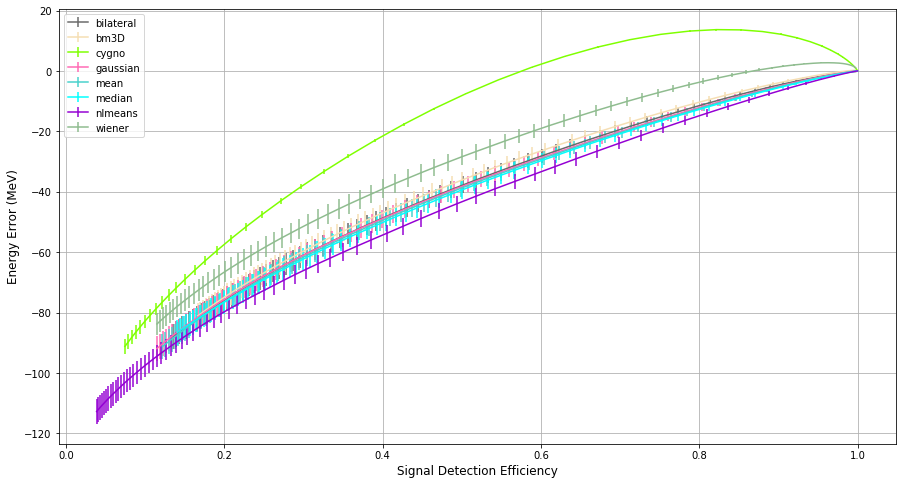

In [49]:
e_factor = 5.9/2000
np.random.seed(287)
fig,ax = plt.subplots(1,1, figsize=(15,8))
filter_names = np.unique(names)
colors_index = np.random.randint(low=0, high=len(color_names), size=len(filter_names))
best_times = []
ind_none = np.where((np.array(names)=='mean'))[0][0]
energy_return = []
for i,filter_name in list(enumerate(filter_names)):
    index = np.where(filter_name == np.array(names))[0]
    best_index = index[f1_best_scores[index].argmax()]
    
    x = sg_eff_mean[:, best_index]
    y = e_factor*energy_real_mean[:, best_index]
    e_xy = interp1d(x, y, fill_value='extrapolate')
    energy_return.append(e_xy(select_signals[i]))
    #best_time = time[best_index, :].astype(np.int64).mean()
    c = color_names[colors_index[i]]
    ax.errorbar(sg_eff_mean[:, best_index], 
                 e_factor*energy_real_mean[:, best_index],
                 yerr = e_factor*energy_real_std[:, best_index]/np.sqrt(100),
                 label = names[best_index],
                 color = c)
ax.grid()
ax.set_xlabel('Signal Detection Efficiency', fontsize=12)
ax.set_ylabel('Energy Error (MeV)', fontsize=12)
ax.legend()   

In [50]:
energy_return

[array(-43.46193154),
 array(-35.50663361),
 array(-43.89485952),
 array(-31.68006199),
 array(-38.75404186),
 array(-37.73918883),
 array(-17.53928917),
 array(-46.71421416)]

## Get best params to send images to clustering

In [18]:
with open('../data/cluster_eval.json', 'r') as JSON:
    json_dict = json.load(JSON)
data = json.loads(json_dict)

FileNotFoundError: [Errno 2] No such file or directory: '../data/cluster_eval.json'

In [46]:
names = data['Filter_name'][0:9]
params = data['Filter_parameter'][0:9]

In [47]:
energy = np.array(data['ROC']['energy'])[range(0,200,2), :, :]
time = np.array(data['time']).reshape(energy.shape[2],energy.shape[0])
energy_mean = energy.mean(axis=0)
energy_std = energy.std(axis=0)

In [48]:
curves = np.array(data['ROC']['array'])
sg_eff = curves[range(0,200,2),0,:,:]
bg_eff = curves[range(0,200,2),1,:,:]
sg_eff.shape

(100, 121, 9)

In [49]:
thresholds = np.array(data['ROC']['threshold'])[range(0,200,2),:,:,0,0]
thresholds.shape

(100, 121, 9)

## How is the threshold behavior?

In [51]:
t = np.zeros((sg_eff.shape[2], sg_eff.shape[0]))
for filter_index in range(0, sg_eff.shape[2]):
    for image_number in range(0, sg_eff.shape[0]):
        x = bg_eff[image_number, :, filter_index]
        y = thresholds[image_number, :, filter_index]
        f_xy = interp1d(x, y)
        t[filter_index, image_number] = f_xy(0.99)

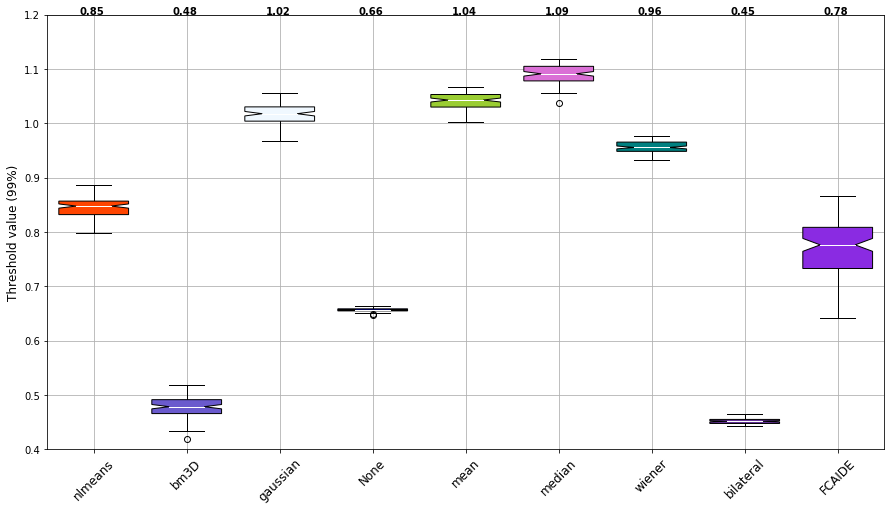

In [56]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
new_color_index = np.append(colors_index,10)
names[3] = 'None'
for i in range(0, t.shape[0]):
    c = color_names[new_color_index[i]]
    ax.boxplot(t[i,:], 
                positions = [i+1],
                patch_artist=True,
                notch = True,
                boxprops=dict(facecolor=c, color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(color='black', markeredgecolor='black'),
                medianprops=dict(color='white'),
                widths = 0.75)
    ax.text(i+1-0.15, 1.2, 
             str('%.2f'%np.median(t[i,:])),
             color = 'black',
             fontweight = 'black')


ax.set_xticklabels(names, rotation=45, fontsize=12)
ax.set_ylim(0.4, 1.2)
ax.set_ylabel('Threshold value (99%)', fontsize=12)
ax.grid()

## Choosing a fix threshold for each method

In [85]:
th_ops = [0.16, 0.09, 0.18, -0.10, 0.11, 0.10, 0.04, 0.09, 0.21]

In [96]:
bg = np.zeros((sg_eff.shape[2], sg_eff.shape[0]))
for filter_index in range(0, sg_eff.shape[2]):
    for image_number in range(0, sg_eff.shape[0]):
        x = bg_eff[image_number, :, filter_index]
        y = thresholds[image_number, :, filter_index]
        f_yx = interp1d(y, x)
        bg[filter_index, image_number] = f_yx(th_ops[filter_index])

In [99]:
bg.mean(axis=1)


array([0.67637126, 0.66141987, 0.68497674, 0.29369072, 0.61298342,
       0.61497323, 0.51937899, 0.60737056, 0.77968361])

In [100]:
bg.std(axis=1)

array([0.00781097, 0.01423483, 0.00529431, 0.00086305, 0.00399782,
       0.00350502, 0.00181103, 0.00350189, 0.02002135])